In [18]:
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import chemprop
from chemprop import data, featurizers, models, nn
from chemprop.featurizers.molecule import RDKit2DFeaturizer
from chemprop.utils import make_mol

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFromModel

from xgboost import XGBRegressor

# from skopt import BayesSearchCV
# from skopt.space import Real, Categorical, Integer
# from skopt.plots import plot_objective
# from skopt.plots import plot_convergence

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [20]:
data_path = '../train_split_fluor.csv'

smiles_columns = ['Chromophore', 'Solvent']
target_columns = ['Absorption max (nm)', 'Emission max (nm)', 'log_q_yield']

In [21]:
num_workers = 0 # number of workers for dataloader. 0 means using main process for data loading
batch_size = 512

In [22]:
data_df = pd.read_csv(data_path)

In [23]:
def drop_extra(df, columns):
    return df[columns]

def dropna(df):
    return df.dropna(subset=['Absorption max (nm)', 'Emission max (nm)', 'Stokes shift', 'Quantum yield'], how='all')

def replace_gas(df):
    df.loc[df['Solvent'] == 'gas', 'Solvent'] = df['Chromophore']
    return df

def remove_neg_shift(df):
    return df[(df['Stokes shift'] >= 0.0) | (df['Stokes shift'].isna())]

def make_log_q_yield(df, eps=1e-5):
    df_tmp = df.copy()
    df_tmp.loc[df_tmp['Quantum yield'] == 0.0, 'Quantum yield'] = eps
    df_tmp.loc[:, 'log_q_yield'] = np.log(df_tmp['Quantum yield'])
    return df_tmp

def delete_outliers(df, columns):
    for column in columns:
        print(column)
        q1 = df[column].quantile(0.25)
        q3 = df[column].quantile(0.75)
        iqr = q3 - q1
        df = df[
            ((df[column] > q1 - 1.5 * iqr) & (df[column] < q3 + 1.5 * iqr))
            | (df[column].isna())
        ]

        print("left", q1 - 1.5 * iqr)
        print("right", q3 + 1.5 * iqr)
        print("=" * 100)
    return df

def preprocess_train(df):
    df = drop_extra(df, smiles_columns + ['Absorption max (nm)', 'Emission max (nm)', 'Stokes shift', 'Quantum yield'])
    df = dropna(df)
    df = replace_gas(df)
    df = remove_neg_shift(df)
    df = make_log_q_yield(df)
    df = drop_extra(df, smiles_columns + target_columns)
    return df

def preprocess_test(df):
    df = drop_extra(df, smiles_columns + ['Absorption max (nm)', 'Emission max (nm)', 'Stokes shift', 'Quantum yield'])
    df = dropna(df)
    df = replace_gas(df)
    df = remove_neg_shift(df)
    df = make_log_q_yield(df)
    df = drop_extra(df, smiles_columns + target_columns)
    return df

In [24]:
data_clean = preprocess_train(data_df)
data_clean.shape

(18110, 5)

In [25]:
smiss = data_clean.loc[:, smiles_columns].values
ys = data_clean.loc[:, target_columns].values

In [26]:
smiss.shape

(18110, 2)

In [27]:
molecule_featurizer = RDKit2DFeaturizer()

def generate_mol_features(smiss, save_file, molecule_featurizer=molecule_featurizer):
    mols = [make_mol(smis, keep_h=False, add_h=False) for smis in smiss]
    extra_datapoint_descriptors = [molecule_featurizer(mol) for mol in tqdm(mols)]
    np.savez(save_file, extra_datapoint_descriptors)
    return extra_datapoint_descriptors

def load_mol_features(save_file):
    extra_mol_features = np.load(save_file)
    return [extra_mol_features[f"arr_{i}"] for i in range(len(extra_mol_features))][0]

/home/kashurin/soft/chemprop/chemprop/featurizers/molecule.py:52: UserWarning: The RDKit 2D features can deviate signifcantly from a normal distribution. Consider manually scaling them using an appropriate scaler before creating datapoints, rather than using the scikit-learn `StandardScaler` (the default in Chemprop).
  warnings.warn(


In [28]:
save_file = '../gnn_3/rdkit_feats_1.npz'
extra_datapoint_descriptors_1 = load_mol_features(save_file)

In [29]:
save_file = '../gnn_3/rdkit_feats_2.npz'
extra_datapoint_descriptors_2 = load_mol_features(save_file)

In [30]:
extra_datapoint_descriptors = np.concatenate((
    extra_datapoint_descriptors_1,
    extra_datapoint_descriptors_2),
    axis=1
)
extra_datapoint_descriptors.shape

(18110, 420)

In [31]:
f_mean = np.mean(np.abs(extra_datapoint_descriptors), axis=0)
mask_2 = ~(f_mean > 1e10) & ~np.isnan(f_mean) & ~(f_mean < 1e-10)

good_indeces = np.where(mask_2)[0]
np.savetxt('good_indeces.txt', good_indeces)

extra_datapoint_descriptors = extra_datapoint_descriptors[:, mask_2]

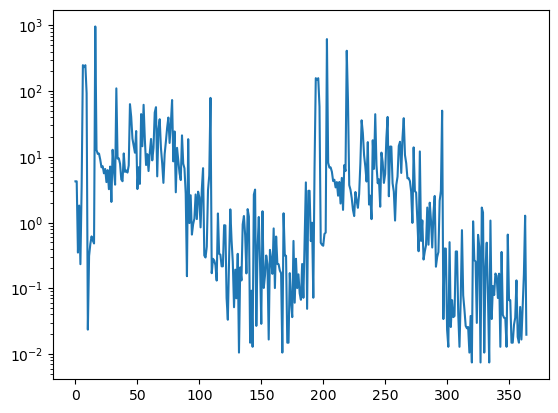

In [32]:
mean_d = np.mean(extra_datapoint_descriptors, axis=0)
std_d = np.std(extra_datapoint_descriptors, axis=0)
# plt.plot(mean_d)
plt.plot(std_d)
plt.yscale('log')
plt.show()

In [33]:
with open("../keys_smiles.yml") as stream:
    try:
        smiles2number = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

In [34]:
with open("../tb_gaps.yml") as stream:
    try:
        number2hl = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

In [35]:
smiles2gap = {}
for k, v in smiles2number.items():
    smiles2gap[k] = number2hl[v]['lumo'] - number2hl[v]['homo']

In [36]:
def filter_data(feats, targets, smiss=smiss[:, 0], smiles2gap=None):
    if smiles2gap is not None:
        gaps = []
        for smis in smiss:
            if smis in smiles2gap:
                gaps.append(smiles2gap[smis])
            else:
                gaps.append(np.nan)
        gaps = np.array(gaps).reshape(-1, 1)
        feats = np.concatenate((feats, gaps), axis=1)
    
    mask = ~np.isnan(targets)\
            & ~np.isnan(feats).any(axis=1) 
            # & np.all(np.abs(feats) < 1e10, axis=1)
    
    targets = targets[mask]
    print(len(targets))
    feats = feats[mask]

    return feats, targets

In [37]:
def get_importance(index, smiles2gap=None, model=None):
    targets = ys[:, index]
    
    feats, targets = filter_data(extra_datapoint_descriptors, targets, smiles2gap=smiles2gap)

    if model is None:
        model = XGBRegressor(
            seed=42,
            device='cuda',
            # n_jobs=multiprocessing.cpu_count() // 4
        )
    
    model.fit(feats, targets)

    return model.feature_importances_


In [38]:
feature_importances_1 = get_importance(0, smiles2gap=None)
feature_importances_2 = get_importance(1, smiles2gap=None)
feature_importances_3 = get_importance(2, smiles2gap=None)

15618
16436
12515


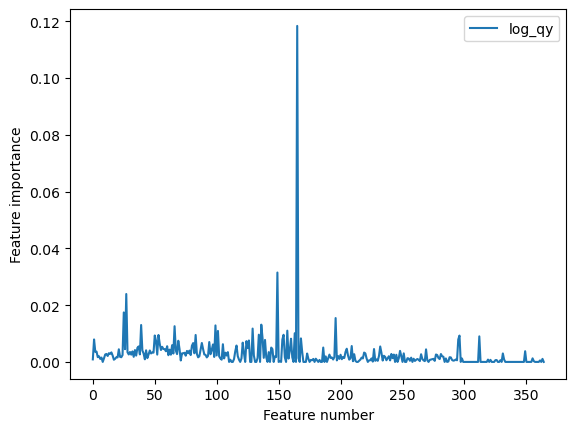

In [39]:
# plt.plot(feature_importances_1, label='abs')
# plt.plot(feature_importances_2, label='emi')
plt.plot(feature_importances_3, label='log_qy')
plt.legend()
plt.ylabel('Feature importance')
plt.xlabel('Feature number')
# plt.yscale('log')
plt.show()

In [113]:
feature_importances = np.mean(np.array([
    feature_importances_1,
    feature_importances_2,
    feature_importances_3
]), axis=0)

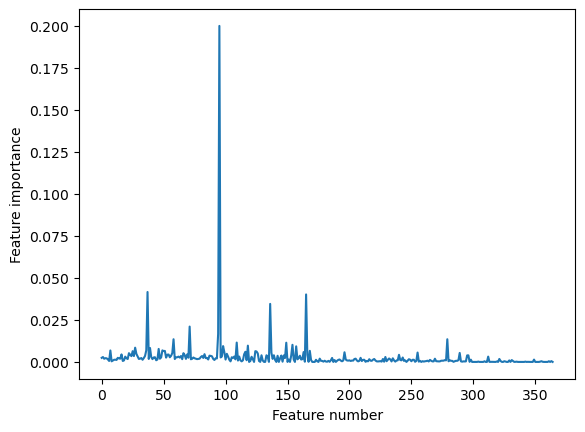

In [114]:
plt.plot(feature_importances)
# plt.yscale('log')
plt.ylabel('Feature importance')
plt.xlabel('Feature number')
plt.show()

In [ ]:
feature_importances_1 = get_importance(0, RandomForestRegressor(random_state=42))
feature_importances_2 = get_importance(1, RandomForestRegressor(random_state=42))
feature_importances_3 = get_importance(2, RandomForestRegressor(random_state=42))

In [ ]:
plt.plot(feature_importances_1, label='abs')
plt.plot(feature_importances_2, label='emi')
plt.plot(feature_importances_3, label='log_qy')
plt.legend()
plt.ylabel('Feature importance')
plt.xlabel('Feature number')
# plt.yscale('log')
plt.show()

In [ ]:
feature_importances = np.mean(np.array([
    feature_importances_1,
    feature_importances_2,
    feature_importances_3
]), axis=0)

In [ ]:
plt.plot(feature_importances)
# plt.yscale('log')
plt.ylabel('Feature importance')
plt.xlabel('Feature number')
plt.show()

In [22]:
# feature_importances_sorted_indeces = np.argsort(-feature_importances)

# sum = 0
# treshold = 0.7
# chosen_indeces = []
# for ind in feature_importances_sorted_indeces:
#     sum += feature_importances[ind]
#     chosen_indeces.append(ind)
#     if sum >= treshold:
#         break

In [40]:
top_k = 20
ind_1 = set(np.argsort(-feature_importances_1)[:top_k])
ind_2 = set(np.argsort(-feature_importances_2)[:top_k])
ind_3 = set(np.argsort(-feature_importances_3)[:top_k])

inds = ind_3
inds = np.array(list(inds))

In [41]:
len(inds)

20

In [42]:
np.savetxt('ind_important_features_lqy.txt', inds)

In [128]:
# feats = extra_datapoint_descriptors[:, inds]

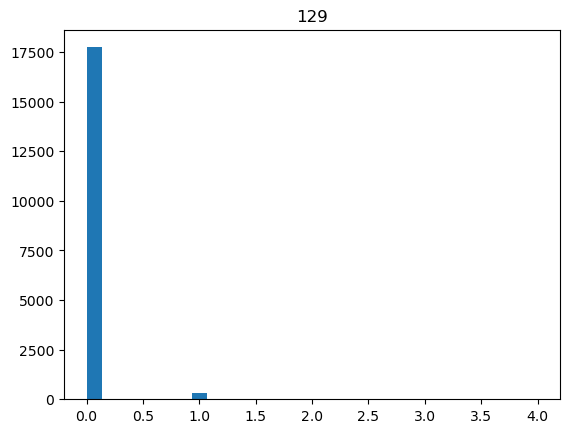

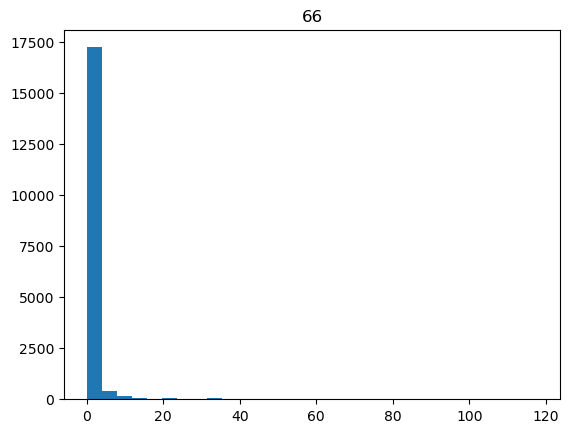

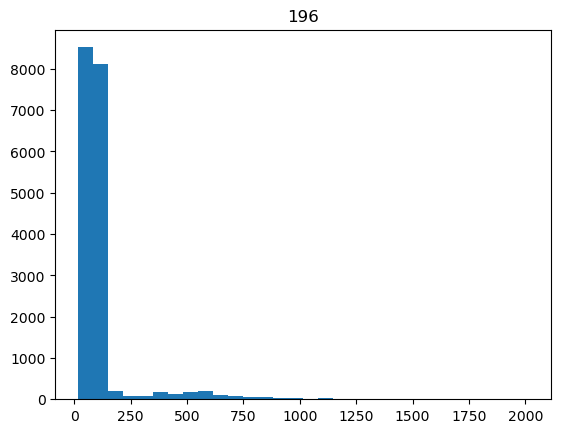

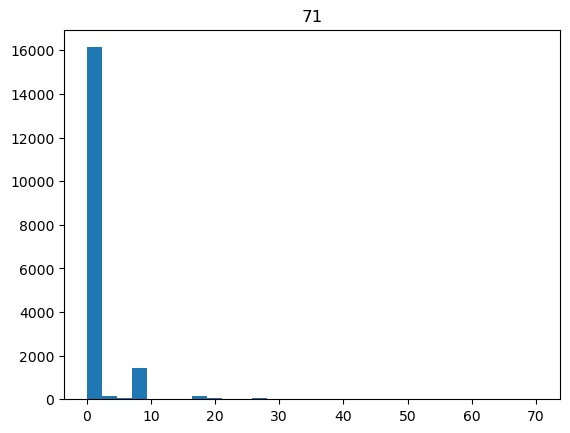

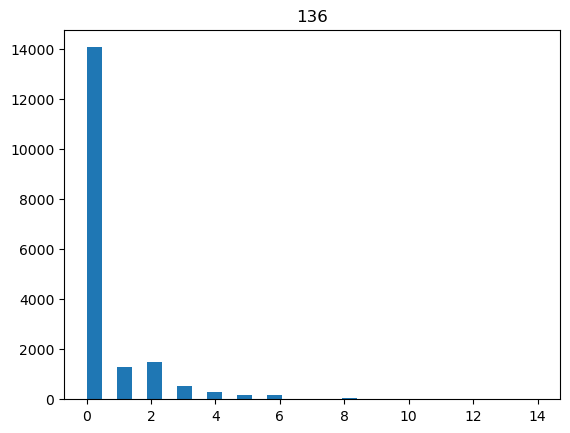

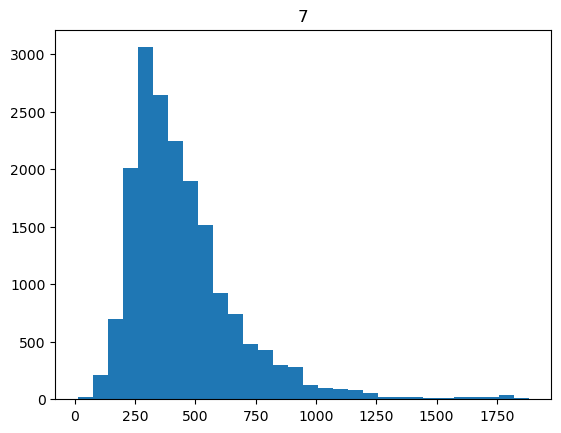

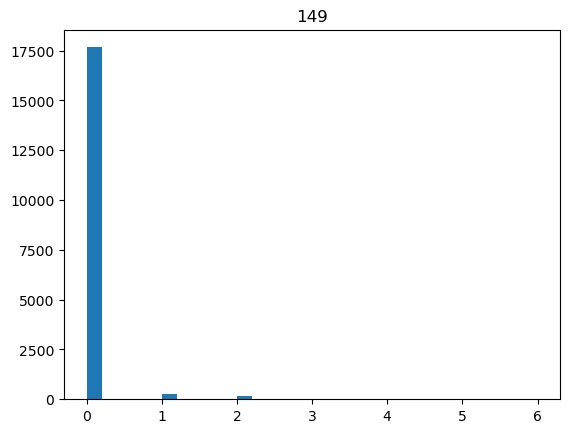

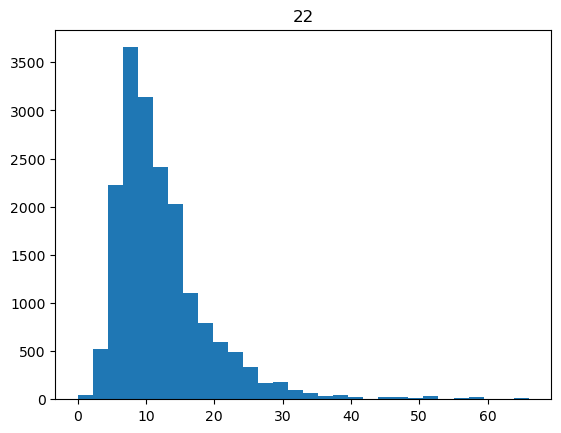

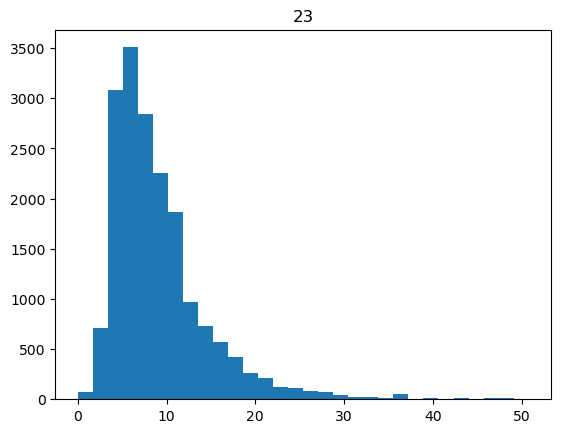

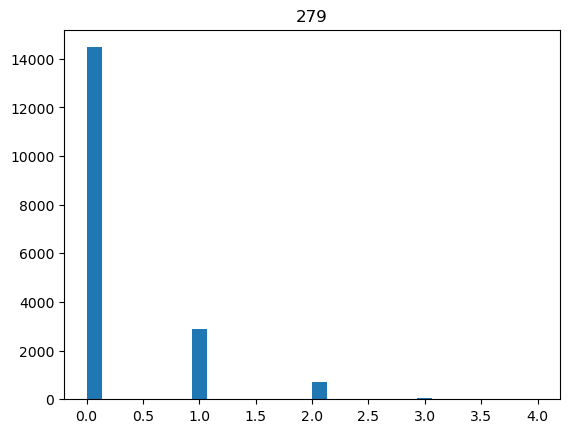

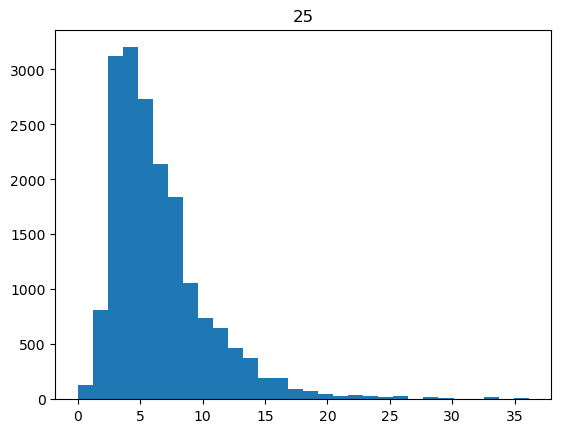

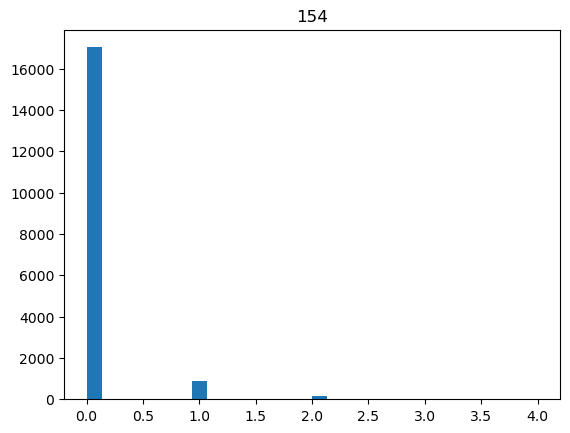

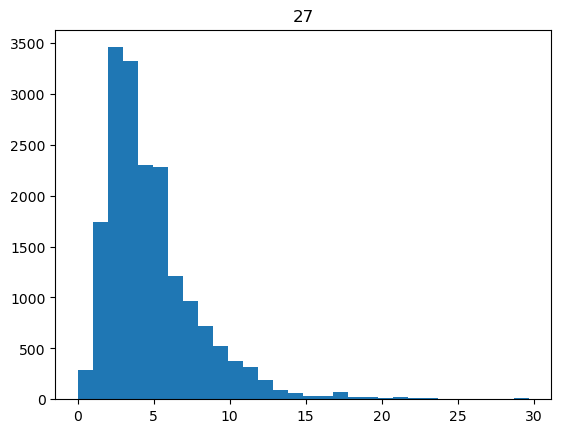

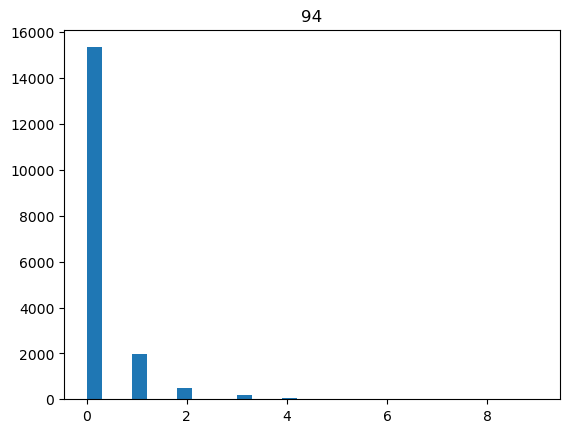

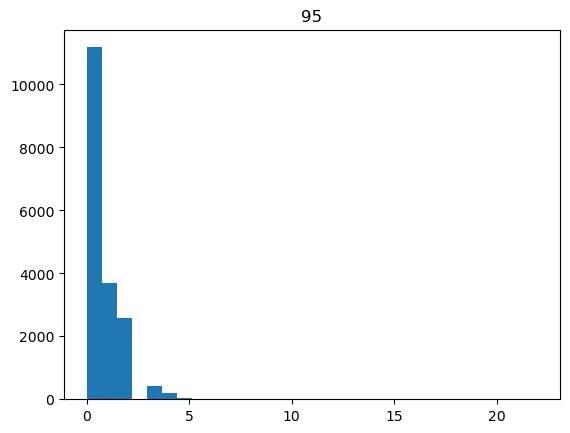

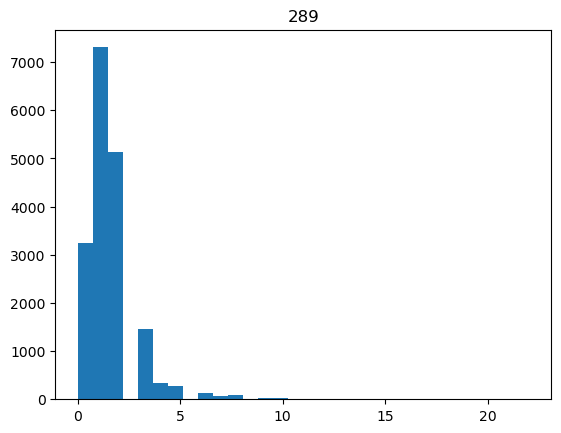

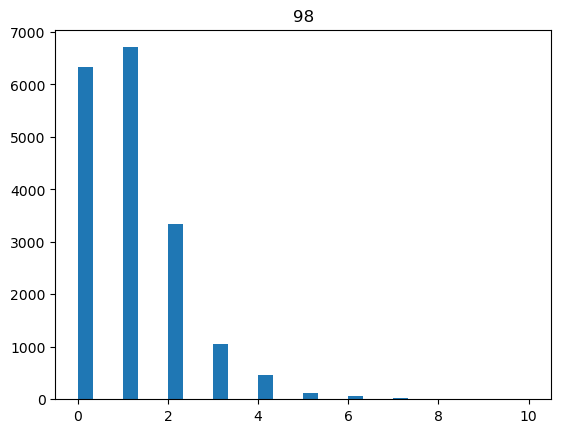

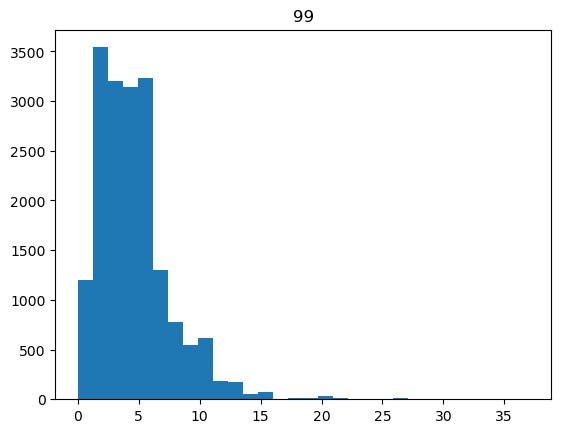

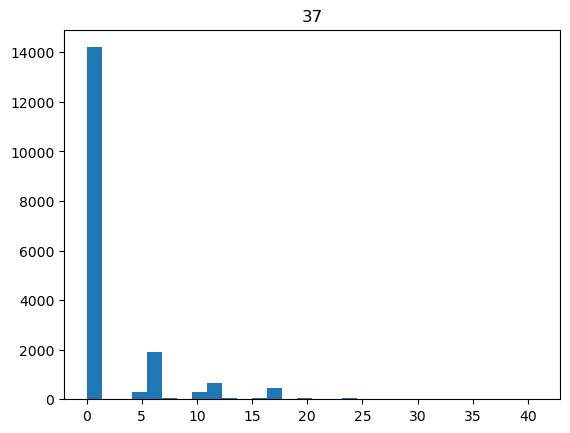

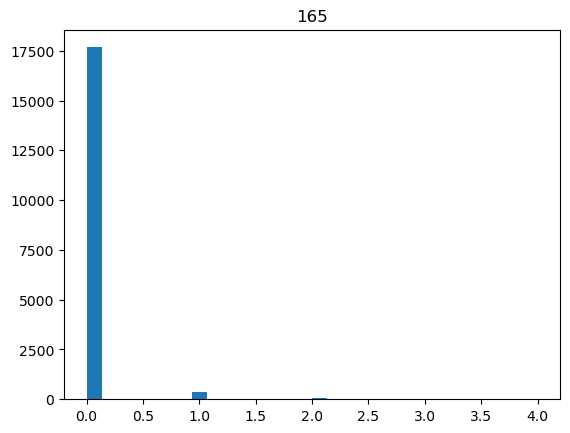

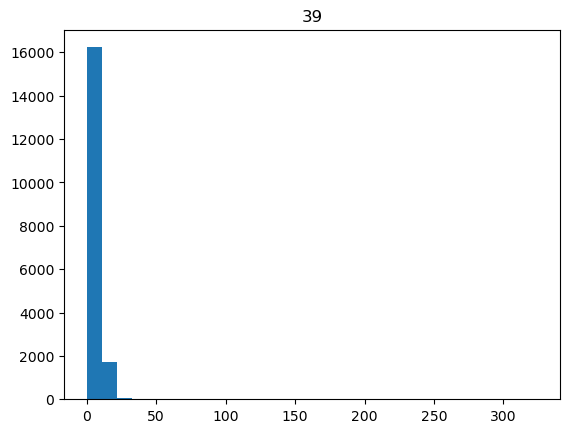

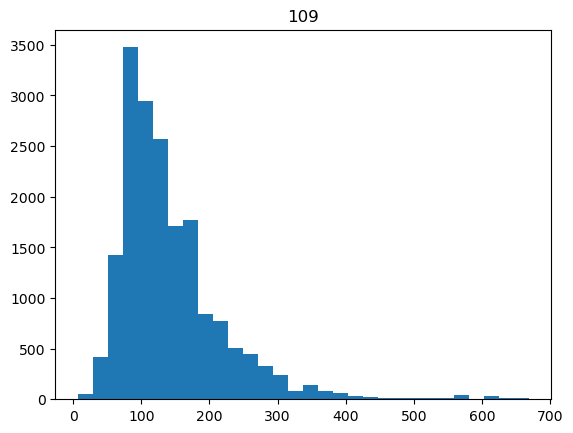

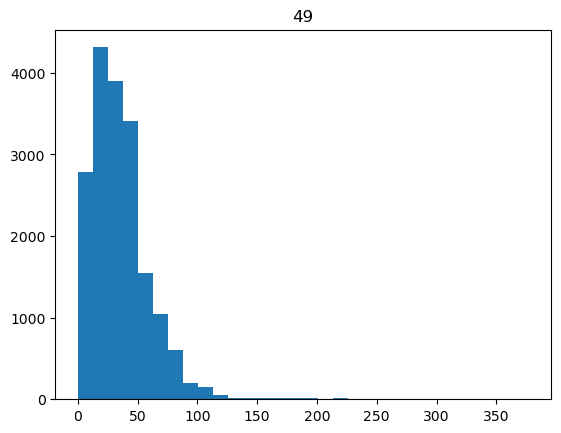

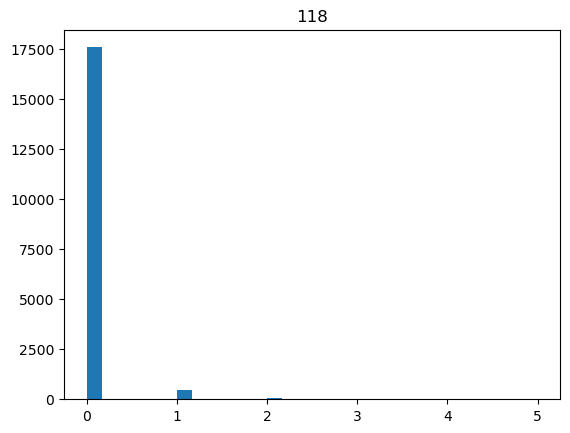

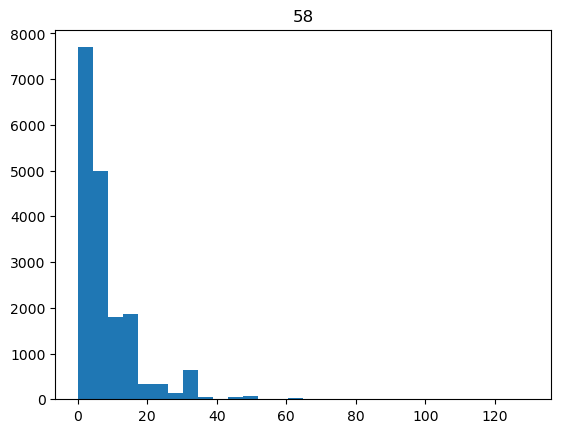

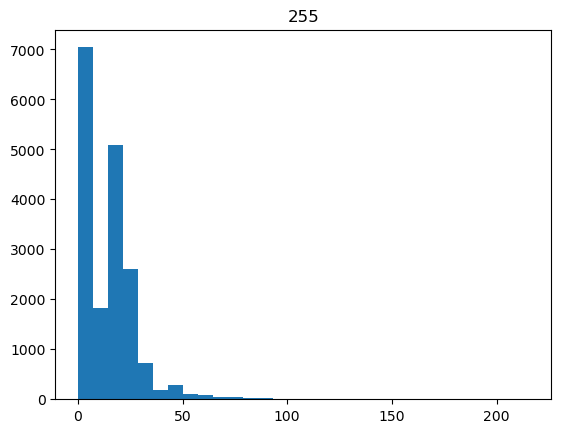

In [129]:
for i in inds:
    plt.hist(extra_datapoint_descriptors[:, i], bins=30)
    plt.title(i)
    plt.show()